Text(0, 0.5, 'Recovery variable')

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


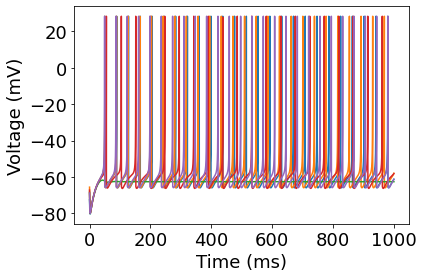

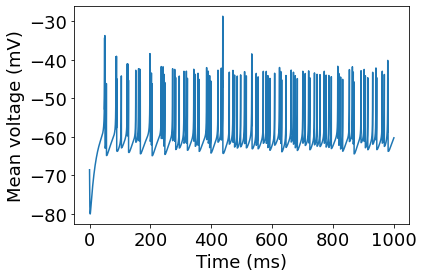

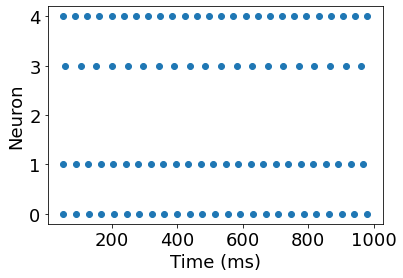

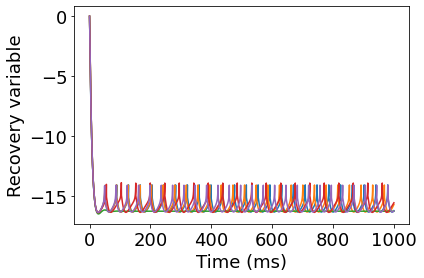

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from scipy.interpolate import interp1d
import scipy.stats as stats

np.random.seed(101)


N = 5
T = 1000               
M = 50000             
dt = 0.005            
t0 = 0                

k = 1                         
a = 0.1              
b = 0.26             
c = -65              
d = -1               
v_reset = c          
v_thresh = 30        

I0 = 0.2
delta = 0.02  
I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))

v_init = np.random.normal(-70,5, size=(N))
u_init = np.zeros(v_init.shape)


t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0


def dxdt(t, x, k, a, b, I):
    v = x[:N]     
    u = x[N:2*N]  
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) 
    dudt = k * a * (b * v - u)  
    
    return np.concatenate([dvdt, dudt])


def v_spike(t, x, k, a, b, I):
    return x[:N].max() - v_thresh   
v_spike.terminal = True
v_spike.direction = 1


while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init])  
    
  
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])  
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)  
    
 
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]    
    u_init = y[N:2*N, -1] 
    
    # Check for spikes
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()  
        
        v_init[spike] = v_reset  
        u_init[spike] += d         
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1


colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)


plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')



plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')



spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')


plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')

Text(0, 0.5, 'Recovery variable')

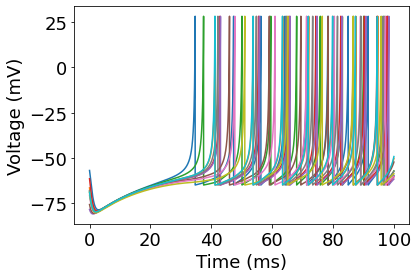

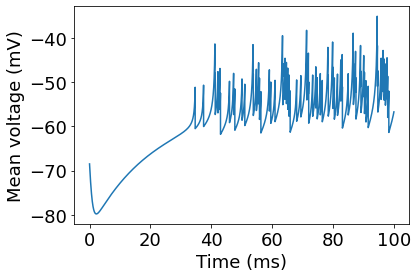

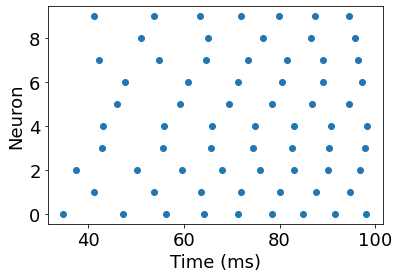

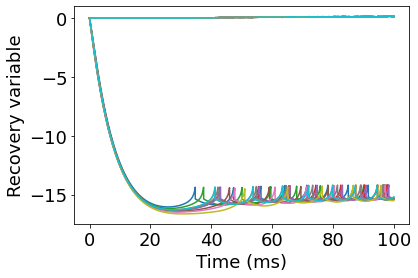

In [2]:
# Need to couple the neurons by adding the 1st order synaptic term
# Also added J term from the paper

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from scipy.interpolate import interp1d
import scipy.stats as stats
import random

np.random.seed(101)

N = 10
T = 100              
M = 50000             
dt = 0.005            
t0 = 0                

k = 1                         
a = 0.1              
b = 0.26             
c = -65              
d = -1               
v_reset = c          
v_thresh = 30

kappa = 0.25
vsyn = 0
tauS = 10

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.2
delta = 0.02  
I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))



v_init = np.random.normal(-70,5, size=(N))
u_init = np.zeros(v_init.shape)
s_init = np.zeros(v_init.shape)


t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0


def dxdt(t, x, k, a, b, I, kappa, s, Vsyn, J):
    v = x[:N]     
    u = x[N:2*N]
    s = x[2*N:3*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I)  + J - kappa*(v - Vsyn)*s  
    dudt = k * a * (b * v - u)
    dsdt = -s/tauS
    
    return np.concatenate([dvdt, dudt, dsdt])


def v_spike(t, x, k, a, b, I, kappa, Vsyn, tauS, J):
    return x[:N].max() - v_thresh   
v_spike.terminal = True
v_spike.direction = 1


while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init])  
    
  
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, kappa, vsyn, tauS, J), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])  
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)  
    
 
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]    
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    
    # Check for spikes
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()  
        
        v_init[spike] = v_reset  
        u_init[spike] += d
        s_init += 1/(tauS*N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1


colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)


plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')



plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')



spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')


plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')

Text(0, 0.5, 'Recovery variable')

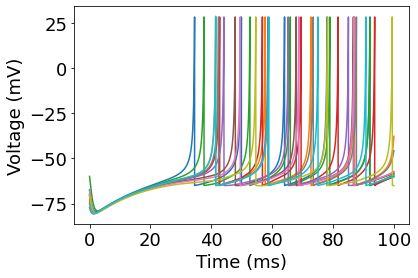

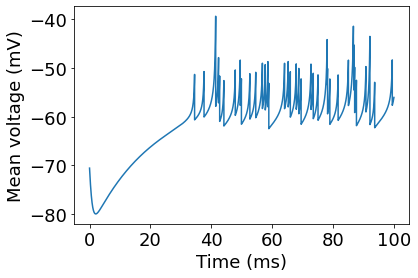

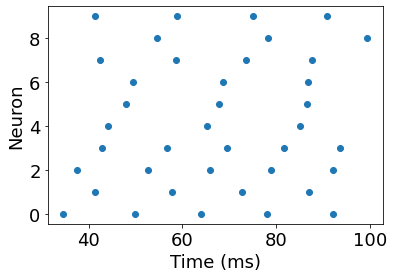

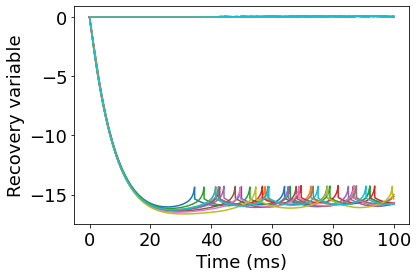

In [3]:
# Sparsely connected networks - g is only non-zero for x amount of randomly chosen neurons
# 1st Order Synaptic Term
np.random.seed(101)

N = 10
T = 100              
M = 50000             
dt = 0.005            
t0 = 0                

k = 1                         
a = 0.1              
b = 0.26             
c = -65              
d = -1               
v_reset = c          
v_thresh = 30

kappa = 0.25
vsyn = 0
tauS = 10

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.2
delta = 0.02  
I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))

Number_Random_Chosen_Neurons = 3

# Define synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks
for j in range(N):
    connections = random.sample(range(N), Number_Random_Chosen_Neurons)  
    for i in connections:
        if i != j:  
            g[j, i] = np.random.uniform(0.05, 0.5)  


# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections

v_init = np.random.normal(-70,5, size=(N))
u_init = np.zeros(v_init.shape)
s_init = np.zeros(v_init.shape)


t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, kappa, vsyn, tauS, J, g):
    v = x[:N]      
    u = x[N:2*N]  
    s = x[2*N:3*N]
        
    dvdt = k*(0.04*v**2 + 5*v + 140 - u + I) + J - kappa*(v - vsyn)*np.dot(g,s) 
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS
    
    return np.concatenate([dvdt, dudt, dsdt])

def v_spike(t, x, k, a, b, I, kappa, Vsyn, tauS, J, g):
    return x[:N].max() - v_thresh   
v_spike.terminal = True
v_spike.direction = 1


while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init])  
    
  
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, kappa, vsyn, tauS, J, g), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])  
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)  
    
 
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]    
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    
    # Check for spikes
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()  
        
        v_init[spike] = v_reset  
        u_init[spike] += d
        s_init += 1/(tauS*N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1


colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')

Text(0, 0.5, 'Recovery variable')

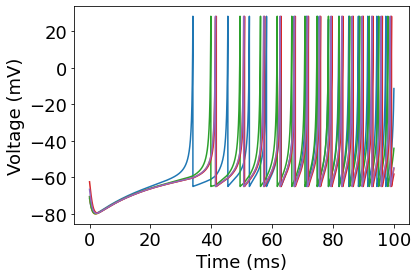

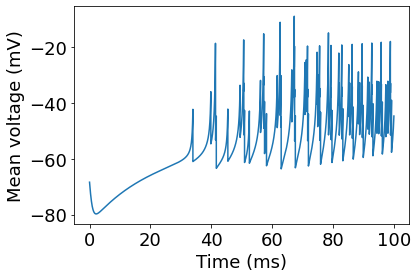

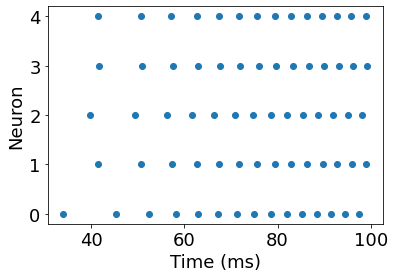

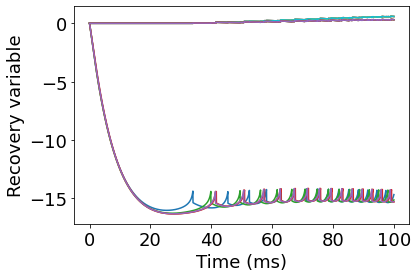

In [4]:
# Need to couple the neurons by adding the 2nd order synaptic term
# Also added J term from the paper

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats

np.random.seed(101)

N = 5
T = 100
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

kappa = 0.25
vsyn = 0
tauS = 10

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.2
delta = 0.02
I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))

v_init = np.random.normal(-70, 5, size=(N))
u_init = np.zeros(v_init.shape)
s_init = np.zeros(v_init.shape)
p_init = np.zeros(v_init.shape)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, kappa, Vsyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - kappa * (v - Vsyn) * s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, kappa, Vsyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, kappa, vsyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        s_init += 1 / (tauS * N)
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')

Text(0, 0.5, 'Recovery variable')

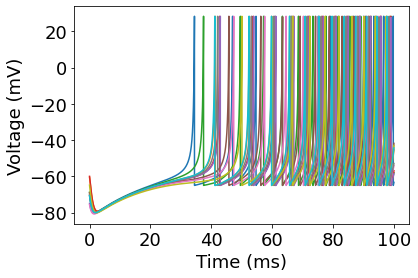

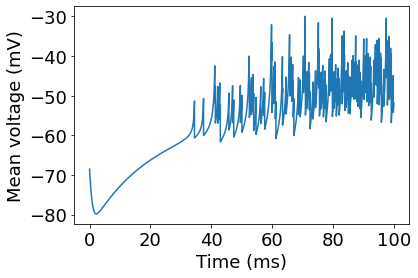

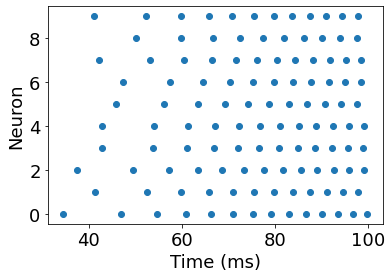

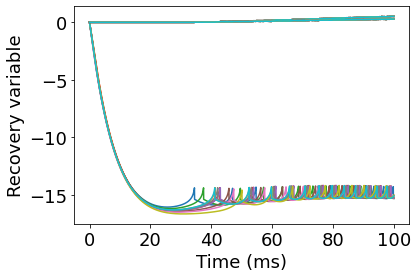

In [5]:
# Making neuron sparsely connected for second order synaptic term

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats

np.random.seed(101)

N = 10
T = 100
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

kappa = 0.25
vsyn = 0
tauS = 10

J = np.random.normal(0, 0.25, size=(N))

I0 = 0.2
delta = 0.02
I = stats.cauchy.rvs(loc=I0, scale=delta, size=(N))

Number_Random_Chosen_Neurons = 3

# Define synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks
for j in range(N):
    connections = random.sample(range(N), Number_Random_Chosen_Neurons)  
    for i in connections:
        if i != j:  
            g[j, i] = np.random.uniform(0.05, 0.5)  


# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.zeros(v_init.shape)
s_init = np.zeros(v_init.shape)
p_init = np.zeros(v_init.shape)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, kappa, Vsyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - kappa * (v - Vsyn) * s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, kappa, Vsyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, kappa, vsyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        s_init += 1 / (tauS * N)
        p_init += 1 / (tauS * N)
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')